# Lab Notebook: Build a `tf.data.Dataset` Object from Labels and Image Files

In order to leverage Tensorflow's high-performance `tf.data` API, we must package our dataset specifically as a `tf.data.Dataset` object. This lab notebook documents and performs this procedure.

## Import dependencies

In [3]:
import csv
import numpy      as np
import pandas     as pd

# Ensure that tensorflow only displays error messages
import tensorflow as tf
from tensorflow import keras
from typing import Union, Literal

# Import utility functions defined in ../common/ package
import sys
sys.path.append('../python/')
from common import *

## Environment Checks
In this section, we perform a number of checks to ensure that we are connected to the right Python kernel (e.g. on a remote compute provider), and that the correct tensorflow version is installed.

First, check the hostname of our system:

In [2]:
!uname -a

Linux philosophy 5.19.0-35-generic #36~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Feb 17 15:17:25 UTC 2 x86_64 x86_64 x86_64 GNU/Linux


Next, check whether GPUs or AI compute accelerators are available

In [3]:
display(tf.config.list_physical_devices('GPU'))
display(tf.test.gpu_device_name())

[]

''

Finally, check that our tensorflow version is at least `2.11.0` or above.

In [4]:
print(tf.__version__)

2.11.0


If the tensorflow version is < 2.11, make sure to upgrade to the latest version of tensorflow:

In [5]:
!pip3 install --upgrade tensorflow==2.11.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 4.1 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 70.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 21.5 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
   

Environment checks are complete. If the tensorflow version had to be upgraded, the Jupyter kernel must be restarted at this point.

# Loading Labels and Images as `tf.data.Dataset` objects

In the next section, we will prepare our radiographs and their labels as a `tf.data.Dataset` object.

## Dataset Files

We begin with the following files:

* `df_labels-onehot`: Metadata and labels in one-hot encoding. Available as a CSV and Pickle.
* `filenames.csv`: A list of filenames in `raw-images/`, in the same order as the labels. Available as CSV.

As well as a directory at `dataset/raw-images/` which contains all the radiographs in `.jpeg` form.

First, ensure that the dataset directory is appropriately located. The filepath will differ depending on whether this notebook is ran locally, or on the remote computing environment.

In [5]:
# On Local:
dataset_directory: str = "./"

# On remote:
# dataset_directory: str = "/datasets/radiographs/data/images/"

The `dataset_directory` prefix will be used on all subsequent operations which refers to filepaths. Now that the prefix is set, we may begin by loading the labels as a dataframe:

In [6]:
df_dataset_labels: pd.DataFrame = pd.read_pickle(dataset_directory + "df_labels-onehot.pkl")
display(df_dataset_labels)

,study_id,record_id,event_arm,view_antpr,view_later,medial_cortex_1,medial_cortex_2,medial_cortex_3,medial_cortex_4,lateral_cortex_1,...,lateral_cortex_3,lateral_cortex_4,anterior_cortex_1,anterior_cortex_2,anterior_cortex_3,anterior_cortex_4,posterior_cortex_1,posterior_cortex_2,posterior_cortex_3,posterior_cortex_4
index,,,,,,,,,,,,,,,,,,,,,
0,pacs,2864,6month_follow_up_arm_1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,pacs,4038,6month_follow_up_arm_1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,pacs,1558,6month_follow_up_arm_1,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,pacs,2768,6month_follow_up_arm_1,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,pacs,5597,6month_follow_up_arm_1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2931,retrodefect,1863,baseline_arm_1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2932,retrodefect,1220,baseline_arm_1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2933,retrodefect,1634,baseline_arm_1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


## Loading one-hot-encoded labels as a tensor

The complete `df_dataset_labels` DataFrame contains both the sample-related metadata (`study_id`, `record_id`, and `event_arm`) as well as the one-hot encoded labels which we need. In this step, we first create a numpy array containing only the one-hot encoded labels `np_labels`, and then convert them into a Tensor called `ts_labels`.

Note the following naming convention that is in use within this notebook:
* `np_`: numpy arrays.
* `ts_`: tensors.
* `ds_`: Tensorflow dataset objects.

In [26]:
np_labels: np.ndarray = df_dataset_labels.iloc[:,3:].to_numpy()
ts_labels: tf.Tensor  = tf.convert_to_tensor(np_labels)

# Creating a Tensorflow Dataset with Images and Labels

Now that we have loaded our labels as a one-hot encoded tensor, our next step is to create a Tensorflow Dataset object (`tf.data.Dataset`) which contains the following: `(images, labels)`, such that:

* Every `image` is a `tf.Tensor` with shape `(height, width, channels)`, denoting an RGB image file.
* Every `label` is a `tf.Tensor` with shape `(18,)`, denoting the 18 one-hot encoded labels.

In order to do this, we must first implement a function which pre-processes (`preprocess_image()`) our images, by converting them from raw binary tensors into JPEG-encoded tensors, casting them into a float, and then re-sizing and re-scaling them to our requirements.

We will start by defining a series of constants that will define our dataset:


In [13]:
BATCH_SIZE: int = 64
IMG_SIZE: tuple[int, int] = (299, 299)
AUTOTUNE: Literal = tf.data.AUTOTUNE
RNG_SEED: int = 1337

Next, we will define the preprocessing function:

In [14]:
def preprocess_image(img: tf.Tensor, size: tuple[int, int] = IMG_SIZE) -> tf.Tensor:
    img = tf.io.decode_jpeg(img, channels=3, try_recover_truncated=True)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, size)
    img = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1.)(img)

    return img

The above `preprocess_image()` function will be used within the following `create_dataset` function, which will iterate over every image file as provided within the `filenames.csv` file, and pass them over to `preprocess_image()`. Because the filenames in `filenames.csv` are sorted in the same order as our labels in `ts_labels`, once this process is complete the `create_dataset()` function can "join" them both together as a `tf.data.Dataset`, by simply passing the tuple `(imgs_list, ts_labels)` to `tf.data.Dataset.from_tensor_slices()`.

In [27]:
def create_dataset(
        csv_path: str,
        imgs_dir: str,
        ts_labels: tf.Tensor,
        debug: bool = True
    ) -> tf.data.Dataset:

    imgs_list: list[tf.Tensor] = []
    with open(csv_path, newline='') as csvfile:
        csvreader = csv.reader(csvfile)
        
        for row in csvreader:
            filename: str = row[0]
            img: tf.Tensor = preprocess_image(tf.io.read_file(imgs_dir + filename))
            imgs_list.append(img)

    ds_dataset: tf.data.Dataset = tf.data.Dataset.from_tensor_slices((imgs_list, ts_labels))
    return ds_dataset

Now using the above function, we create our dataset. This `tf.data.Dataset` object represents the *complete* and *unsplit* dataset. We will make our train-test-validation splits later.

In [28]:
ts_labels

<tf.Tensor: shape=(2936, 18), dtype=uint8, numpy=
array([[1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0]], dtype=uint8)>

In [30]:
ds_dataset: tf.data.Dataset = create_dataset(
    csv_path=dataset_directory + 'filenames.csv',
    imgs_dir=dataset_directory + "raw-images/",
    ts_labels=ts_labels,
)

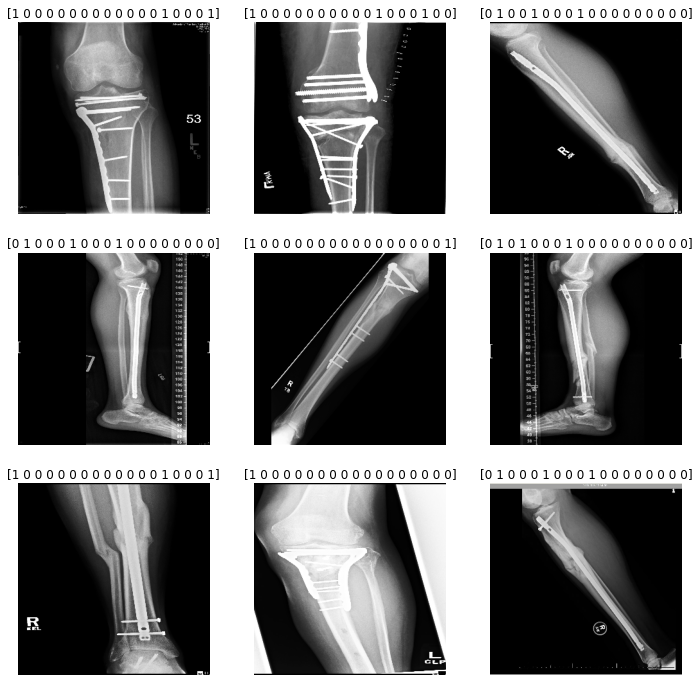

In [32]:
display(preview_dataset(ds_dataset))

# Making Train Test Split

Now that our data is available as a unsplit `ds_dataset` dataset, we must perform our splits. Note that the `ds_dataset` dataset is unshuffled, we will also shuffle our data in this step. Splitting will be performed using the `keras.utils.split_dataset()` function.

## Train Test Validation split:

* Total: 2936 (100%)
* Train: 2055 (70%)
* Valid:  440 (15%)
* Test :  441 (15%)

In [33]:
# First, testing data is split from the whole containing training and validation data
ds_train_valid, ds_test = keras.utils.split_dataset(
    ds_dataset,
    left_size=2495,
    right_size=441,
    shuffle=True,
    seed=RNG_SEED
)

# Next, validation data is split from the training data.
ds_train, ds_valid = keras.utils.split_dataset(
    ds_train_valid,
    left_size=2055,
    right_size=440,
    shuffle=False,  # Shuffling already done in original split.
)

# Print summery of dataset
print(f"ds_train: {tf.data.experimental.cardinality(ds_train)}")
print(f"ds_valid: {tf.data.experimental.cardinality(ds_valid)}")
print(f"ds_test:  {tf.data.experimental.cardinality(ds_test)}")

ds_train: 2055
ds_valid: 440
ds_test:  441


Now our datasets are prepared and ready for use in training. We will save them in the following directories for ease-of-use.

In [34]:
ds_train.save(dataset_directory + "ds_train")
ds_valid.save(dataset_directory + "ds_valid")
ds_test.save( dataset_directory + "ds_test")